<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [1]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

sys.path.append("TabularDataGeneration")
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Actual device: {device}')

Cloning into 'TabularDataGeneration'...
remote: Enumerating objects: 4108, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 4108 (delta 82), reused 57 (delta 35), pack-reused 3968 (from 1)
Receiving objects: 100% (4108/4108), 144.08 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (513/513), done.
Actual device: cuda


In [3]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

feature_dim = 64
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 64, 64])
Tumor Labels: ['Glioma', 'Clear', 'Meningioma', 'Clear', 'Glioma', 'Glioma', 'Clear', 'Clear', 'Glioma', 'Pituitary', 'Clear', 'Glioma', 'Pituitary', 'Glioma', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Clear', 'Glioma', 'Pituitary', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Clear', 'Clear', 'Pituitary', 'Clear', 'Clear', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Glioma', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Pituitary', 'Glioma', 'Pituitary', 'Clear']
Section Label: ['Coronal', 'Axial', 'Sagittal', 'Sagittal', 'Coronal', 'Coronal', 'Axial', 'Axial', 'Coronal', 'Sagittal', 'Coronal', 'Sagittal', 'Axial', 'Coronal', 'Sagittal', 'Axial', 'Sagittal', 'Sagittal', '

1: Meningioma  Axial
2: Meningioma  Sagittal
3: Glioma  Axial
4: Glioma  Sagittal
5: Glioma  Sagittal
6: Pituitary  Coronal
7: Meningioma  Coronal
8: Meningioma  Axial
9: Glioma  Coronal
10: Glioma  Axial
11: Glioma  Coronal
12: Glioma  Axial
13: Glioma  Coronal
14: Meningioma  Axial
15: Meningioma  Coronal
16: Pituitary  Coronal
17: Meningioma  Coronal
18: Clear  Axial
19: Glioma  Sagittal
20: Clear  Axial
21: Meningioma  Axial
22: Glioma  Sagittal
23: Pituitary  Coronal
24: Pituitary  Coronal
25: Pituitary  Axial
26: Clear  Axial
27: Meningioma  Sagittal
28: Glioma  Sagittal
29: Meningioma  Sagittal
30: Pituitary  Coronal
31: Pituitary  Coronal
32: Pituitary  Axial
33: Pituitary  Axial
34: Glioma  Coronal
35: Clear  Sagittal
36: Clear  Sagittal
37: Meningioma  Coronal
38: Meningioma  Axial
39: Pituitary  Coronal
40: Clear  Axial
41: Glioma  Axial
42: Meningioma  Axial
43: Clear  Sagittal
44: Meningioma  Sagittal
45: Glioma  Axial
46: Pituitary  Sagittal
47: Glioma  Axial
48: Pituitar

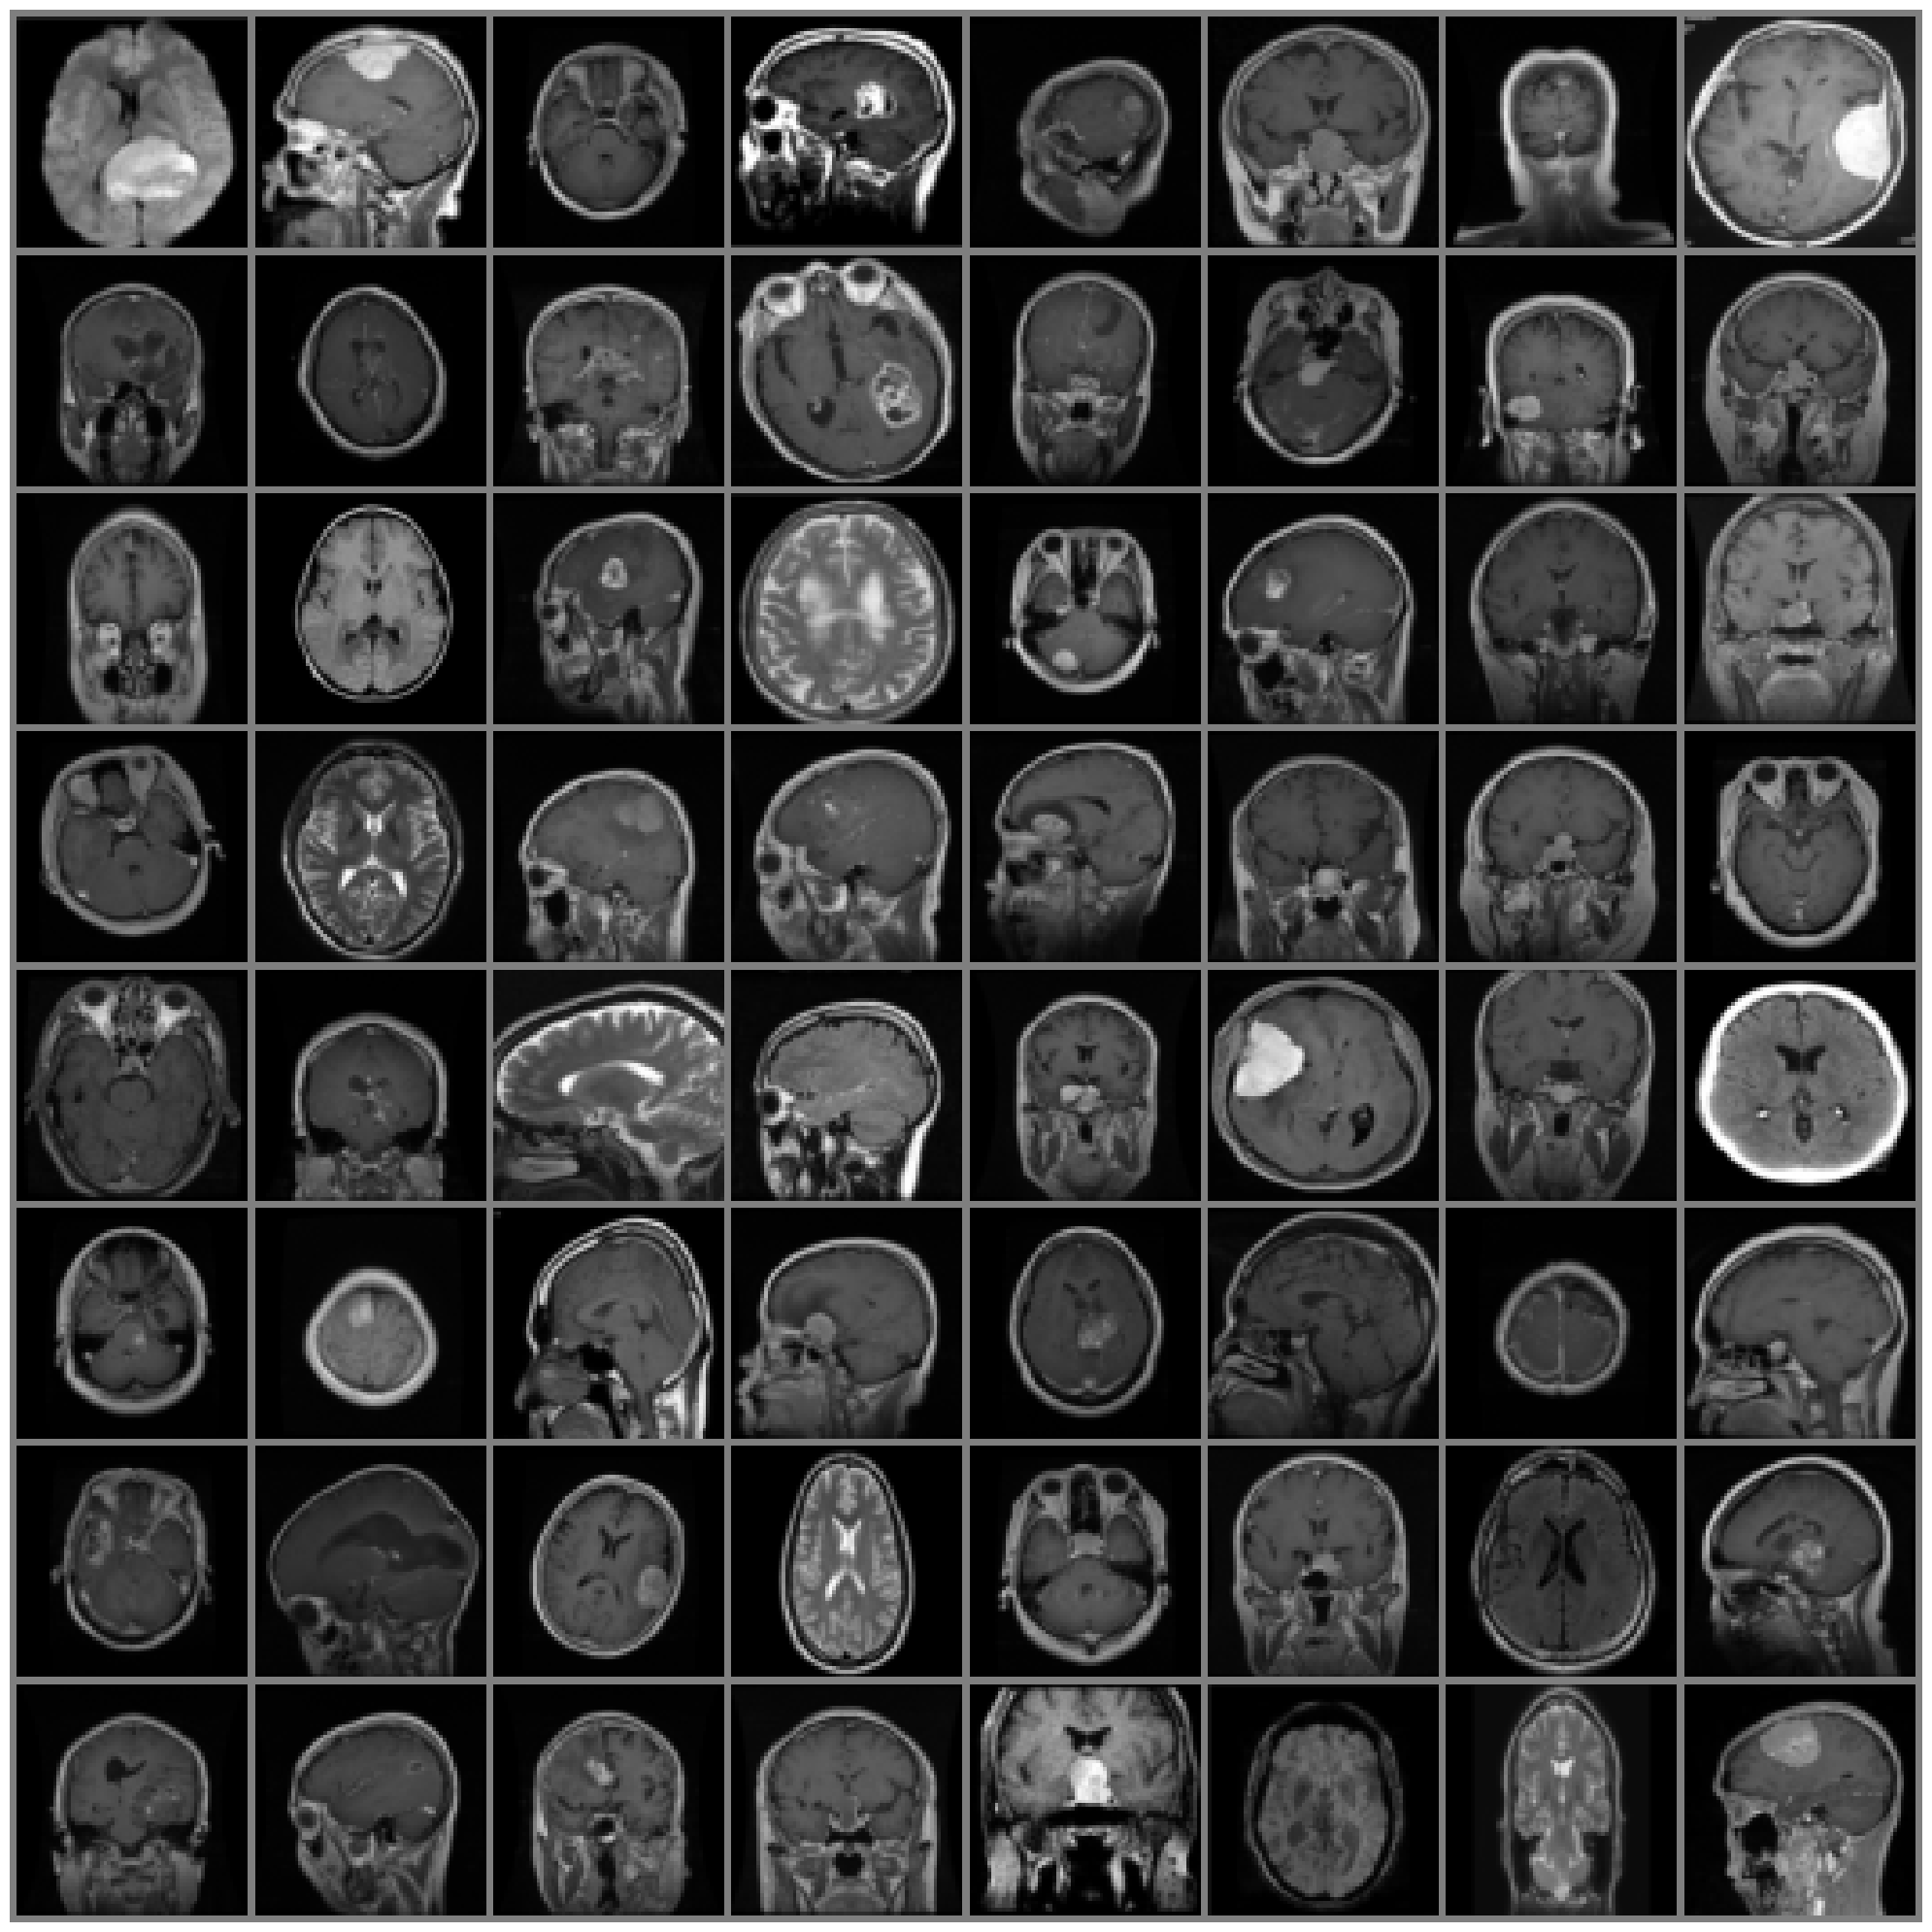

In [4]:
num_images = 64

dataiter = iter(dataloader)
images, labels = next(dataiter)

tumor_name = [tumor_mapping[int(i)] for i in labels[0][:num_images]]
section_name = [section_mapping[int(i)] for i in labels[1][:num_images]]
scan_name = [f"{tumor_name[i]}  {section_name[i]}" for i in range(len(tumor_name))]

for idx, label in enumerate(scan_name):
  print(f"{idx + 1}: {label}")
images = images[:num_images]
grid_img = vutils.make_grid(images, nrow = int(num_images ** 0.5), normalize = True, pad_value = 0.5)
plt.figure(figsize = (int(num_images ** 0.5)*2.5,(int(num_images ** 0.5)*2.5)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout();

In [5]:
class WCriticTinyVGG(nn.Module):
  def __init__(self, tumor_classes, section_classes, feature_dim):
        super(WCriticTinyVGG, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_features = None

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_wasserstein = None

        self._initialize_fc(feature_dim)

  def _initialize_fc(self, feature_dim):
      with torch.no_grad():
          dummy = torch.randn(1, 1, feature_dim, feature_dim)
          out = self.Conv1(dummy)
          out = self.Conv2(out)
          out = self.Conv3(out)
          out = self.Conv4(out)
          flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
      self.fc_features = nn.Linear(flatten_dim, feature_dim)
      self.fc_wasserstein = nn.Linear(feature_dim * 2, 1)

  def forward(self, x, tumor_labels, section_labels):
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.Conv3(x)
    x = self.Conv4(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.fc_features(x)

    tumor_emb = self.fc_tumor(tumor_labels)
    section_emb = self.fc_section(section_labels)

    x = torch.cat((x, tumor_emb, section_emb), dim=1)

    x = self.fc_wasserstein(x)

    return x


class WGeneratorTinyVGG(nn.Module):
    def __init__(self, tumor_classes, section_classes, feature_dim, latent_dim = 100):
        super(WGeneratorTinyVGG, self).__init__()

        self.latent_dim = latent_dim

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_input = nn.Linear(latent_dim + feature_dim, 10 * 13 * 13)

        self.TConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 2, output_padding = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size = 3, stride = 2, output_padding = 1),
            nn.Tanh()
        )

    def forward(self, z, tumor_labels, section_labels):
        tumor_emb = self.fc_tumor(tumor_labels)
        section_emb = self.fc_section(section_labels)

        x = torch.cat((z, tumor_emb, section_emb), dim = 1)
        x = self.fc_input(x)

        x = x.view(-1, 10, 13, 13)

        x = self.TConv1(x)
        x = self.TConv2(x)
        x = self.TConv3(x)
        x = self.TConv4(x)

        return x


utils.set_seed()
crit = WCriticTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
gen = WGeneratorTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000}k')
print(f"Generator output shape: {gen(torch.randn(BS, 100), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')

Critic output shape: torch.Size([64, 1])
Critic parameters: 111.407k
Generator output shape: torch.Size([64, 1, 64, 64])
Generator parameters: 280.895k


In [6]:
def gradient_penalty(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the gradient penalty term for stabilizing WGAN-GP training.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled gradient penalty value to be added to the critic's loss.
    """
    batch_size = real_data.size(0)
    device = real_data.device  # Assicuriamoci di operare sullo stesso device

    # Generiamo pesi casuali per l'interpolazione
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real_data.device)  # Aggiungiamo dimensioni extra
    epsilon = epsilon.expand_as(real_data)  # Ora combacia con [batch_size, channels, height, width]

    # Interpoliamo tra real_data e fake_data
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo il punteggio per i dati interpolati, passando entrambe le etichette
    interpolated_score = critic(interpolated, tumor_labels, section_labels)

    # Calcoliamo il gradiente
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calcoliamo la norma del gradiente e la penalità
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()

    return penalty

def critic_loss(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the critic loss for a WGAN-GP, including the gradient penalty.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled value of the critic's loss.
    """
    real_score = critic(real_data, tumor_labels, section_labels)
    fake_score = critic(fake_data, tumor_labels, section_labels)

    wasserstein_loss = fake_score.mean() - real_score.mean()

    gp = gradient_penalty(critic, real_data, fake_data, tumor_labels, section_labels, lambda_gp)
    return wasserstein_loss + gp

def generator_loss(critic: torch.nn.Module, fake_data: torch.Tensor, tumor_labels: torch.Tensor, section_labels: torch.Tensor):
    """
    Calculates the loss of the generator in a WGAN-GP for image generation.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        fake_data (torch.Tensor): Batch of generated images with shape (batch_size, 1, H, W).
        tumor_labels (torch.Tensor): Tensor with tumor class labels.
        section_labels (torch.Tensor): Tensor with section class labels.

    Returns:
        torch.Tensor: Scaled value of the generator loss.
    """
    fake_score = critic(fake_data, tumor_labels, section_labels)
    return -fake_score.mean()

In [7]:
data = images
fake_data = gen(torch.randn(BS, 100), labels[0], labels[1]).detach().cpu()
print(critic_loss(crit, data, fake_data, labels[0], labels[1]))
print(generator_loss(crit, fake_data, labels[0], labels[1]))

tensor(9.8419, grad_fn=<AddBackward0>)
tensor(0.1445, grad_fn=<NegBackward0>)


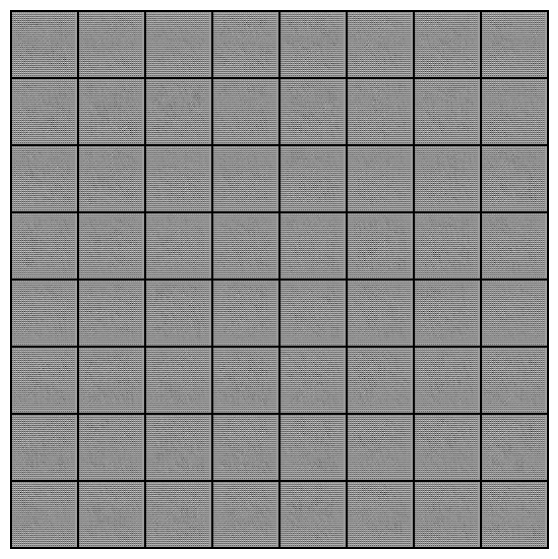

In [8]:
utils.set_seed()
noise = torch.randn(BS, 100)

tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
section_label = torch.randint(low = 0, high = 3, size = (BS,))
utils.generate_images(gen, noise, tumor_labels, section_label, BS)

In [11]:
load_pretrained = True
models_path = 'TabularDataGeneration/BrainTumor/Models/'

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

if load_pretrained:
  print('Parameters loaded!')
  crit.load_state_dict(torch.load(models_path + "TinyVGGcritic.pth"))
  gen.load_state_dict(torch.load(models_path + "TinyVGGgenerator.pth"))
else:
  print('Parameters initialized')
  crit.apply(weights_init)
  gen.apply(weights_init)

g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay = 0)

utils.set_seed()
z = torch.randn(BS, 100)

fixed_tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
fixed_section_label = torch.randint(low = 0, high = 3, size = (BS,))

Parameters loaded!


Training Model:   0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch0/50 | CLoss: -58.4357 | GLoss: -0.3007


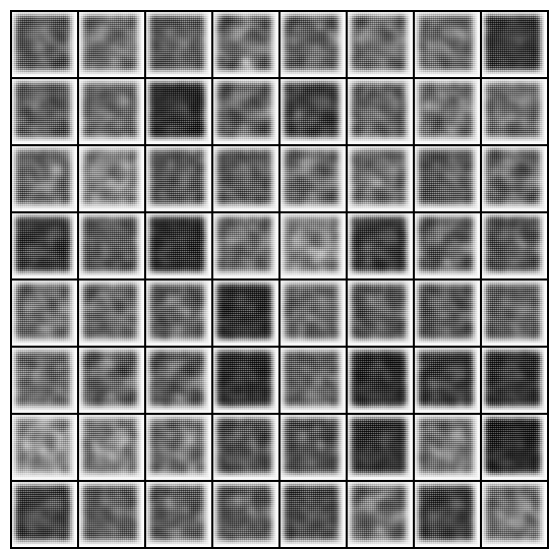

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch5/50 | CLoss: -70.4521 | GLoss: 0.0000


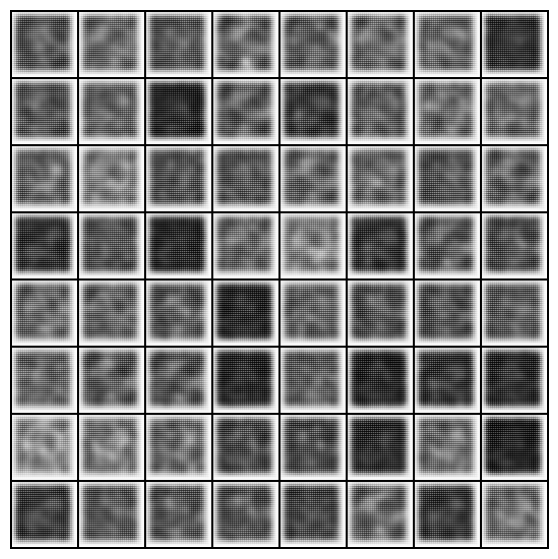

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch10/50 | CLoss: -68.5796 | GLoss: 0.0031


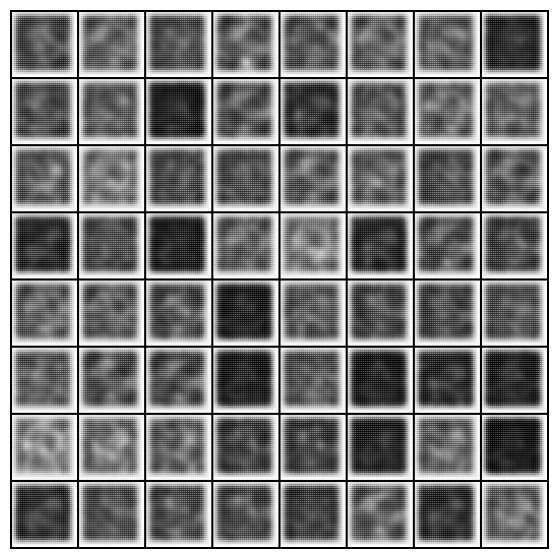

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch15/50 | CLoss: -66.9789 | GLoss: 0.0000


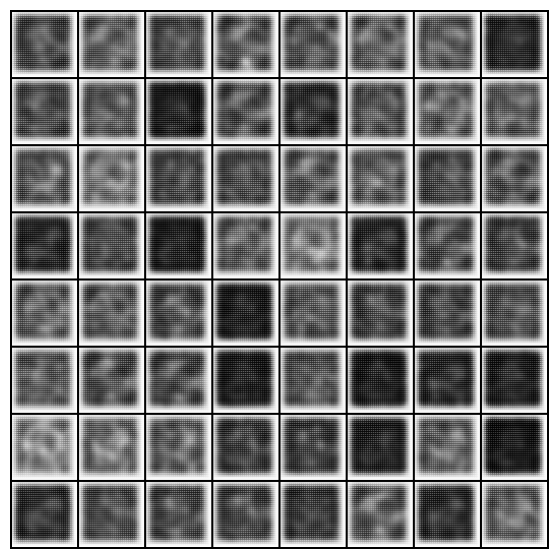

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch20/50 | CLoss: -65.6342 | GLoss: -0.2091


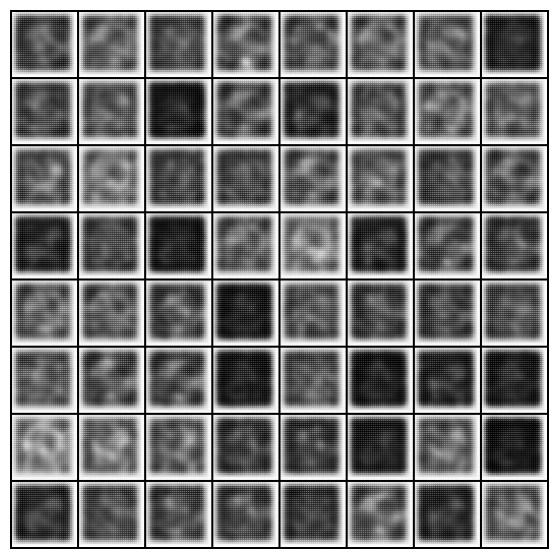

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch25/50 | CLoss: -64.8601 | GLoss: 0.0000


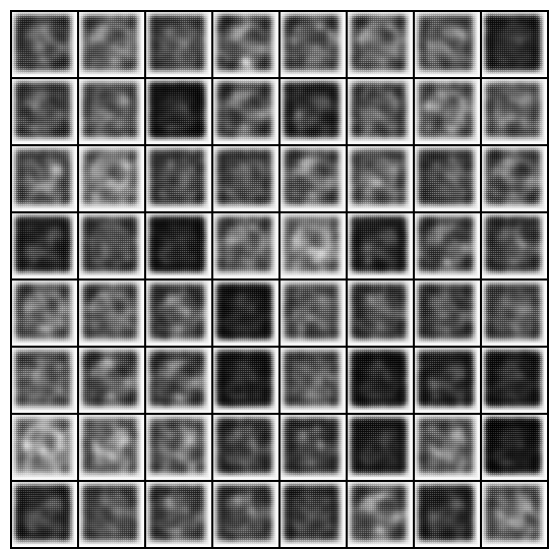

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch30/50 | CLoss: -63.6899 | GLoss: -0.1496


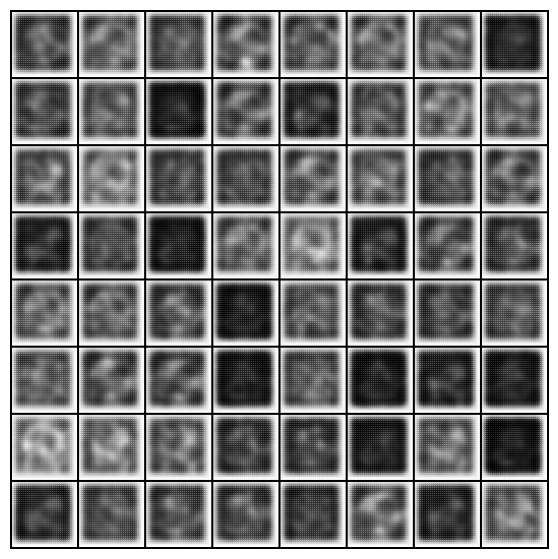

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch35/50 | CLoss: -62.8078 | GLoss: 0.0000


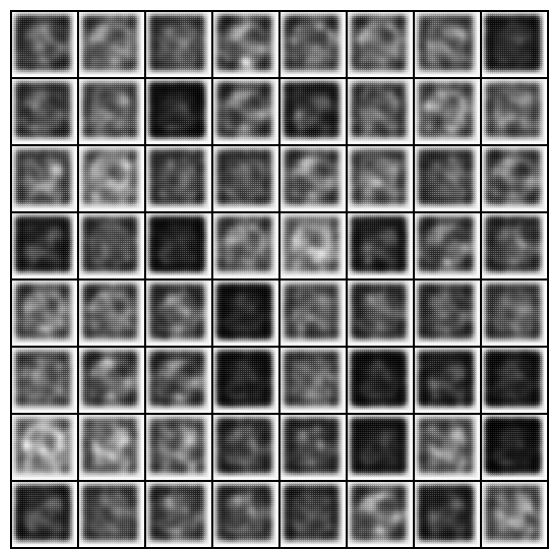

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch40/50 | CLoss: -62.2759 | GLoss: -0.1862


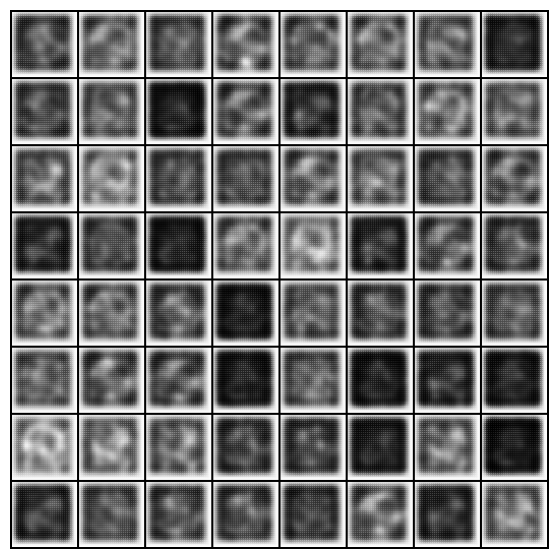

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch45/50 | CLoss: -61.0287 | GLoss: 0.0000


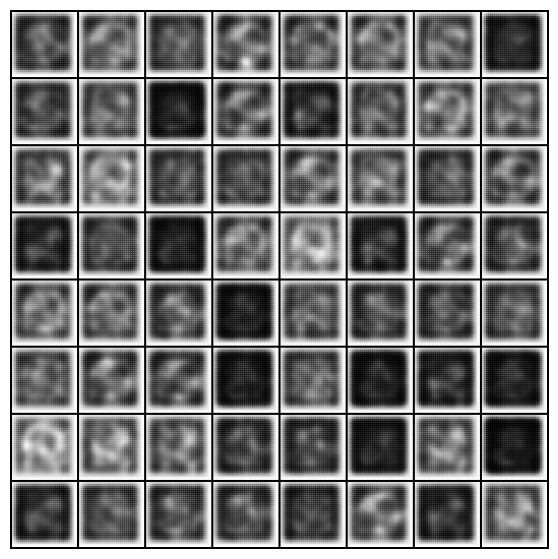

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch50/50 | CLoss: -60.5754 | GLoss: 0.1927


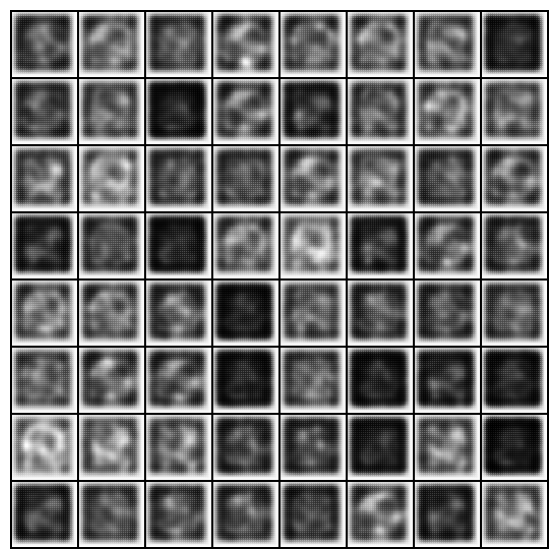

In [12]:
epochs = 50
verbose = 0.1
noise_dim = 100

for epoch in tqdm(range(epochs + 1), desc = 'Training Model'):

  gen = gen.to(device)
  crit = crit.to(device)

  gen.train()
  crit.train()

  gen_epoch_loss = 0
  crit_epoch_loss = 0

  for data, labels in tqdm(dataloader):

    data = data.to(device)
    tumor_labels = labels[0].to(device)
    section_labels = labels[1].to(device)

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    c_opt.zero_grad()
    crit_loss = critic_loss(crit, data, fake_data, tumor_labels, section_labels)
    crit_epoch_loss += crit_loss.item()
    crit_loss.backward()
    c_opt.step()

  if epoch % 2 == 0:

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    g_opt.zero_grad()
    gen_loss = generator_loss(crit, fake_data, tumor_labels, section_labels)
    gen_epoch_loss += gen_loss.item()
    gen_loss.backward()
    g_opt.step()

  g_epoch_loss = gen_epoch_loss/len(dataloader)
  c_epoch_loss = crit_epoch_loss/len(dataloader)

  if epoch % (epochs * 0.1) == 0 or epoch == epochs:
    print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")
    utils.generate_images(gen, z, fixed_tumor_labels, fixed_section_label, BS)

In [33]:
torch.save(crit.state_dict(), "TinyVGGcritic.pth")
torch.save(gen.state_dict(), "TinyVGGgenerator.pth")